In [ ]:
# Simple Moirai Inference and Visualization
# Load model, run inference, and visualize results

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download
import warnings
warnings.filterwarnings('ignore')

from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

# Configuration
MODEL = "moirai"  # or "moirai-moe"
SIZE = "large"    # small, base, large
CTX = 256          # Context length
PDT = 8           # Prediction length
BSZ = 32          # Batch size
GPU = 0           # GPU device
PSZ = 1
compression_ratio = 0.5

# Data configuration
CSV_PATH = "/home/sa53869/time-series/moirai/time-moe-eval/synthetic_sinusoidal.csv"
COLUMN = 2        # Column to analyze (0-indexed)


 = 100 # Test set length

# Set GPU
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)

print(f"Configuration:")
print(f"  Model: {MODEL}-{SIZE}")
print(f"  Context Length: {CTX}")
print(f"  Prediction Length: {PDT}")
print(f"  Test Length: {TEST_LENGTH}")
print(f"  Using GPU: {GPU}")

# Load and prepare data
print("Loading data...")
df = pd.read_csv(CSV_PATH, index_col=0, parse_dates=True)
dataset_name = os.path.splitext(os.path.basename(CSV_PATH))[0]

# Select column
available_columns = df.columns.tolist()
selected_column = available_columns[COLUMN]
df_selected = df[[selected_column]].copy()

print(f"Dataset: {dataset_name}")
print(f"Selected column: {selected_column}")
print(f"Data shape: {df_selected.shape}")
print(f"Data preview:")
print(df_selected.head())

# Create results directory
results_dir = f"results_prune_1/{dataset_name}_{MODEL}-{SIZE}"
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

# Create GluonTS dataset
ds = PandasDataset(dict(df_selected))
train, test_template = split(ds, offset=-TEST_LENGTH)

# Generate test instances
test_data = test_template.generate_instances(
    prediction_length=PDT,
    windows=TEST_LENGTH // PDT,
    distance=PDT,
)

print(f"Number of test windows: {TEST_LENGTH // PDT}")

# Load Moirai model
print("Loading Moirai model...")
base_module = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}")

# Create model with specific configuration
model = MoiraiForecast(
    module=base_module,
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,  # Number of samples for probabilistic forecasting
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

# Create model with reduced context length
reduced_ctx = int(compression_ratio * CTX)
model_reduced = MoiraiForecast(
    module=base_module,
    prediction_length=PDT,
    context_length=reduced_ctx,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

# Create predictor
predictor = model.create_predictor(batch_size=BSZ)
# Create predictor with reduced context length
predictor_reduced = model_reduced.create_predictor(batch_size=BSZ)
print("Model loaded successfully!")

# Run inference on test data
print("Running inference...")
input_data = list(test_data.input)
label_data = list(test_data.label)

# create a new input data with every second value for reduced context; start by duplicating the input data and replacing the 'target' in each item
print("\nPreparing reduced context data...")
input_data_reduced = []
for item in tqdm(input_data, desc="Processing reduced context"):
    # Create a deep copy of the item to avoid modifying original
    reduced_item = item.copy()
    
    # Replace target with every second value (50% reduction)
    original_target = item['target']
    reduced_target = original_target[::2]  # Take every 2nd sample
    reduced_item['target'] = reduced_target
    
    # Update other time-related fields if they exist
    # Note: start time usually stays the same, but we might need to adjust other fields
    
    input_data_reduced.append(reduced_item)

# Run predictions with progress bars
print("\nRunning main inference...")
forecasts = list(tqdm(predictor.predict(input_data), desc="Main forecasts", total=len(input_data)))

print("Running reduced context inference...")
forecasts_reduced = list(tqdm(predictor_reduced.predict(input_data_reduced), desc="Reduced forecasts", total=len(input_data_reduced)))

print(f"Generated {len(forecasts)} forecasts")

# Prepare data for visualization
print("\nProcessing main results...")
sample_results = []
full_data_values = df_selected[selected_column].values

for i, (input_item, label_item, forecast) in enumerate(tqdm(zip(input_data, label_data, forecasts), desc="Processing main results", total=len(input_data))):
    # Get context data
    context = input_item['target']
    
    # keep the last `CTX` values for context
    if len(context) > CTX:
        context = context[-CTX:]

    # Get ground truth
    ground_truth = label_item['target'][:PDT]
    
    # Get prediction (mean of samples)
    prediction = np.mean(forecast.samples, axis=0)
    
    # Store results
    sample_results.append({
        'window_id': i,
        'context': context,
        'ground_truth': ground_truth,
        'prediction': prediction,
        'mae': np.mean(np.abs(prediction - ground_truth))
    })

print(f"Processed {len(sample_results)} samples")

# repeat for reduced context length
print("\nProcessing reduced results...")
sample_results_reduced = []
for i, (input_item, label_item, forecast) in enumerate(tqdm(zip(input_data_reduced, label_data, forecasts_reduced), desc="Processing reduced results", total=len(input_data_reduced))):
    # Get context data
    context = input_item['target']
    
    # keep the last `reduced_ctx` values for context
    if len(context) > reduced_ctx:
        context = context[-reduced_ctx:]

    # Get ground truth
    ground_truth = label_item['target'][:PDT]
    
    # Get prediction (mean of samples)
    prediction = np.mean(forecast.samples, axis=0)
    
    # Store results
    sample_results_reduced.append({
        'window_id': i,
        'context': context,
        'ground_truth': ground_truth,
        'prediction': prediction,
        'mae': np.mean(np.abs(prediction - ground_truth))
    })

# create a new input data with every second value replaced by 0 and then refilled using interpolation
# This maintains the original context length but tests robustness to missing data
print("\nPreparing interpolated context data...")
input_data_reduced_interpolated = []
for item in tqdm(input_data, desc="Processing interpolated context"):
    # Create a deep copy of the item to avoid modifying original
    reduced_item = item.copy()
    
    # Start with original target
    original_target = item['target']
    target_with_zeros = original_target.copy()
    
    # Replace every second value with 0 (creating missing values)
    target_with_zeros[1::2] = 0  # Set every second value to 0
    
    # Create mask for non-zero values (valid data points)
    valid_mask = target_with_zeros != 0
    valid_indices = np.where(valid_mask)[0]
    valid_values = target_with_zeros[valid_mask]
    
    # Interpolate to fill the zero positions
    all_indices = np.arange(len(target_with_zeros))
    interpolated_target = np.interp(all_indices, valid_indices, valid_values)
    
    # Keep the same context length as original
    if len(interpolated_target) > CTX:
        interpolated_target = interpolated_target[-CTX:]
    
    reduced_item['target'] = interpolated_target
    input_data_reduced_interpolated.append(reduced_item)

# Run predictions with interpolated reduced context
print("Running interpolated context inference...")
forecasts_reduced_interpolated = list(tqdm(predictor.predict(input_data_reduced_interpolated), desc="Interpolated forecasts", total=len(input_data_reduced_interpolated)))

# Prepare data for visualization with interpolated reduced context
print("\nProcessing interpolated results...")
sample_results_reduced_interpolated = []
for i, (input_item, label_item, forecast) in enumerate(tqdm(zip(input_data_reduced_interpolated, label_data, forecasts_reduced_interpolated), desc="Processing interpolated results", total=len(input_data_reduced_interpolated))):
    # Get context data
    context = input_item['target']
    
    # Get ground truth
    ground_truth = label_item['target'][:PDT]
    
    # Get prediction (mean of samples)
    prediction = np.mean(forecast.samples, axis=0)
    
    # Store results
    sample_results_reduced_interpolated.append({
        'window_id': i,
        'context': context,
        'ground_truth': ground_truth,
        'prediction': prediction,
        'mae': np.mean(np.abs(prediction - ground_truth))
    })

# create a new input data with only the most recent values (truncated context)
# This maintains the reduced context length but uses only the most recent data
print("\nPreparing truncated context data...")
input_data_truncated = []
for item in tqdm(input_data, desc="Processing truncated context"):
    # Create a deep copy of the item to avoid modifying original
    truncated_item = item.copy()
    
    # Take only the most recent values to match reduced context length
    original_target = item['target']
    
    # Take the last reduced_ctx values (most recent)
    if len(original_target) > reduced_ctx:
        truncated_target = original_target[-reduced_ctx:]
    else:
        truncated_target = original_target
    
    truncated_item['target'] = truncated_target
    input_data_truncated.append(truncated_item)

# Run predictions with truncated context
print("Running truncated context inference...")
forecasts_truncated = list(tqdm(predictor_reduced.predict(input_data_truncated), desc="Truncated forecasts", total=len(input_data_truncated)))

# Prepare data for visualization with truncated context
print("\nProcessing truncated results...")
sample_results_truncated = []
for i, (input_item, label_item, forecast) in enumerate(tqdm(zip(input_data_truncated, label_data, forecasts_truncated), desc="Processing truncated results", total=len(input_data_truncated))):
    # Get context data
    context = input_item['target']
    
    # Get ground truth
    ground_truth = label_item['target'][:PDT]
    
    # Get prediction (mean of samples)
    prediction = np.mean(forecast.samples, axis=0)
    
    # Store results
    sample_results_truncated.append({
        'window_id': i,
        'context': context,
        'ground_truth': ground_truth,
        'prediction': prediction,
        'mae': np.mean(np.abs(prediction - ground_truth))
    })

Configuration:
  Model: moirai-large
  Context Length: 256
  Prediction Length: 8
  Test Length: 100
  Using GPU: 0
Loading data...
Dataset: synthetic_sinusoidal
Selected column: SIN_WITH_SPIKES
Data shape: (200000, 1)
Data preview:
                     SIN_WITH_SPIKES
date                                
2024-01-01 00:00:00         6.000000
2024-01-01 01:00:00         6.870858
2024-01-01 02:00:00         7.666718
2024-01-01 03:00:00         8.319040
2024-01-01 04:00:00         8.771645
Results will be saved to: results_prune_1/synthetic_sinusoidal_moirai-large
Number of test windows: 12
Loading Moirai model...
Model loaded successfully!
Running inference...

Preparing reduced context data...


Processing reduced context: 100%|██████████| 12/12 [00:00<00:00, 189216.72it/s]



Running main inference...


Main forecasts: 100%|██████████| 12/12 [00:00<00:00, 42.08it/s]


Running reduced context inference...


Reduced forecasts: 100%|██████████| 12/12 [00:00<00:00, 102.00it/s]


Generated 12 forecasts

Processing main results...


Processing main results: 100%|██████████| 12/12 [00:00<00:00, 25103.07it/s]


Processed 12 samples

Processing reduced results...


Processing reduced results: 100%|██████████| 12/12 [00:00<00:00, 30578.16it/s]



Preparing interpolated context data...


Processing interpolated context: 100%|██████████| 12/12 [00:00<00:00, 433.34it/s]


Running interpolated context inference...


Interpolated forecasts: 100%|██████████| 12/12 [00:00<00:00, 58.40it/s]



Processing interpolated results...


Processing interpolated results: 100%|██████████| 12/12 [00:00<00:00, 27324.46it/s]



Preparing truncated context data...


Processing truncated context: 100%|██████████| 12/12 [00:00<00:00, 193583.26it/s]


Running truncated context inference...


Truncated forecasts: 100%|██████████| 12/12 [00:00<00:00, 105.00it/s]



Processing truncated results...


Processing truncated results: 100%|██████████| 12/12 [00:00<00:00, 29262.59it/s]


In [51]:
# Implement uncertainty-based pruning methods
# Method 1: Drop least important 50% of samples (shorter context)
# Method 2: Replace least important 50% with interpolation (original length)

print("\n" + "="*60)
print("IMPLEMENTING UNCERTAINTY-BASED PRUNING METHODS")
print("="*60)

# First, create the autoregressive model needed for uncertainty computation
print("Creating autoregressive model for uncertainty computation...")
model_ar = MoiraiForecast(
    module=base_module,
    prediction_length=1,  # Single-step predictions
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor_ar = model_ar.create_predictor(batch_size=BSZ)
print("Autoregressive predictor created successfully!")

def compute_uncertainty_importance(context_2x, predictor_ar, CTX, template_item):
    """
    Compute uncertainty/importance for each position in the last CTX samples.
    Higher uncertainty = higher importance.
    
    Args:
        context_2x: Array of length 2*CTX containing the last 2*CTX samples
        predictor_ar: Autoregressive predictor for single-step predictions
        CTX: Context length
        template_item: Template item for creating AR predictions
        
    Returns:
        uncertainty_scores: Array of length CTX with uncertainty scores for the last CTX samples
    """
    # Ensure we have exactly 2*CTX samples
    if len(context_2x) != 2*CTX:
        raise ValueError(f"Expected context of length {2*CTX}, got {len(context_2x)}")
    
    # Generate autoregressive predictions for each of the last CTX samples
    # Use sliding windows: predict sample CTX+1 using samples 1:CTX, predict sample CTX+2 using samples 2:CTX+1, etc.
    input_data_context = []
    
    for j in range(CTX):
        # Create input for autoregressive prediction
        ar_item = template_item.copy()
        
        # Extract context window of length CTX starting from position j
        # This predicts the (j+CTX)th sample using samples j:(j+CTX)
        ar_item['target'] = context_2x[j:j + CTX]
        input_data_context.append(ar_item)
    
    try:
        # Generate single-step autoregressive predictions
        forecasts_ar = list(predictor_ar.predict(input_data_context))
        
        # Calculate uncertainty from autoregressive predictions
        # Uncertainty = coefficient of variation (std/mean)
        context_samples = np.array([f.samples for f in forecasts_ar])
        context_mean = np.mean(context_samples, axis=1)
        context_std = np.std(context_samples, axis=1)
        context_uncertainty = context_std / (np.abs(context_mean) + 1e-8)
        
        # Return uncertainty scores for the last CTX samples
        return context_uncertainty.flatten()
        
    except Exception as e:
        print(f"Warning: Error in uncertainty computation: {e}")
        # Fallback: use position-based importance (more recent = more important)
        uncertainty_scores = np.linspace(0.1, 1.0, CTX)  # Increasing importance for more recent samples
        return uncertainty_scores

# Method 1: Uncertainty-based pruning with shorter context
print("\nMethod 1: Uncertainty-based pruning (drop least important 50%)")
input_data_uncertainty_short = []

# Store uncertainty data for the selected samples for later visualization
selected_samples_data = {}

for i, item in enumerate(tqdm(input_data, desc="Processing uncertainty-based short context")):
    # Create a copy of the item
    pruned_item = item.copy()
    
    # Get original context
    original_target = item['target']
    
    # Extract the last 2*CTX samples for uncertainty computation
    if len(original_target) >= 2*CTX:
        context_2x = original_target[-2*CTX:]
    else:
        # If we don't have enough data, pad with zeros at the beginning
        padding_needed = 2*CTX - len(original_target)
        context_2x = np.concatenate([np.zeros(padding_needed), original_target])

    # Compute uncertainty/importance for the last CTX positions
    uncertainty_scores = compute_uncertainty_importance(context_2x, predictor_ar, CTX, item)
    
    # Extract the actual last CTX samples
    if len(original_target) >= CTX:
        last_ctx_samples = original_target[-CTX:]
    else:
        # Pad if needed
        padding_needed = CTX - len(original_target)
        last_ctx_samples = np.concatenate([np.zeros(padding_needed), original_target])
    
    # Store data for selected samples (we'll use the same sample_indices from the main plotting)
    # For now, store for the first few samples - we'll filter later
    if i < 50:  # Store more than needed, filter later
        # Calculate deltas: delta[i] = x[i] - x[i-1]
        # For a signal of length CTX, we get CTX-1 deltas (no delta for the first position)
        signal_deltas = np.diff(last_ctx_samples)  # This gives delta[1], delta[2], ..., delta[CTX-1]
        
        # Create padded delta array where delta[0] = 0 (no delta for first position)
        # and delta[i] = x[i] - x[i-1] for i = 1, 2, ..., CTX-1
        padded_deltas = np.zeros(CTX)
        padded_deltas[1:] = signal_deltas  # delta[i] is stored at position i
        
        selected_samples_data[i] = {
            'signal': last_ctx_samples,
            'uncertainty': uncertainty_scores,
            'delta': padded_deltas  # Now delta[i] represents x[i] - x[i-1]
        }
    
    # Keep only the top 50% most important (highest uncertainty) samples from the last CTX
    num_keep = CTX // 2
    important_indices = np.argsort(uncertainty_scores)[-num_keep:]  # Top 50% most uncertain/important
    important_indices = np.sort(important_indices)  # Maintain temporal order
    
    # Create pruned target with only important samples from the last CTX
    pruned_target = last_ctx_samples[important_indices]
    pruned_item['target'] = pruned_target
    
    input_data_uncertainty_short.append(pruned_item)

print(f"Created {len(input_data_uncertainty_short)} inputs with uncertainty-based pruning (short context)")

# Method 2: Uncertainty-based pruning with interpolation (original CTX length)
print("\nMethod 2: Uncertainty-based pruning with interpolation (original CTX length)")
input_data_uncertainty_interpolated = []
for i, item in enumerate(tqdm(input_data, desc="Processing uncertainty-based interpolated context")):
    # Create a copy of the item
    interpolated_item = item.copy()
    
    # Get original context
    original_target = item['target']
    
    # Extract the last 2*CTX samples for uncertainty computation
    if len(original_target) >= 2*CTX:
        context_2x = original_target[-2*CTX:]
    else:
        # If we don't have enough data, pad with zeros at the beginning
        padding_needed = 2*CTX - len(original_target)
        context_2x = np.concatenate([np.zeros(padding_needed), original_target])

    # Compute uncertainty/importance for the last CTX positions
    uncertainty_scores = compute_uncertainty_importance(context_2x, predictor_ar, CTX, item)
    
    # Extract the actual last CTX samples
    if len(original_target) >= CTX:
        last_ctx_samples = original_target[-CTX:]
    else:
        # Pad if needed
        padding_needed = CTX - len(original_target)
        last_ctx_samples = np.concatenate([np.zeros(padding_needed), original_target])
    
    # Identify least important 50% of samples to replace in the last CTX
    num_replace = CTX // 2
    least_important_indices = np.argsort(uncertainty_scores)[:num_replace]  # Bottom 50% least uncertain/important
    
    # Create target with least important samples set to NaN (for interpolation)
    target_with_missing = last_ctx_samples.copy().astype(float)
    target_with_missing[least_important_indices] = np.nan
    
    # Interpolate missing values
    valid_indices = ~np.isnan(target_with_missing)
    if np.sum(valid_indices) > 1:  # Need at least 2 points to interpolate
        all_indices = np.arange(len(target_with_missing))
        interpolated_target = np.interp(
            all_indices,
            all_indices[valid_indices],
            target_with_missing[valid_indices]
        )
    else:
        # Fallback: use original if interpolation fails
        interpolated_target = last_ctx_samples
    
    interpolated_item['target'] = interpolated_target
    input_data_uncertainty_interpolated.append(interpolated_item)

print(f"Created {len(input_data_uncertainty_interpolated)} inputs with uncertainty-based interpolation")

# Run predictions for uncertainty-based methods
print("\nRunning inference with uncertainty-based pruning methods...")

# Method 1: Shorter context predictions
print("Running predictions with uncertainty-based short context...")
forecasts_uncertainty_short = list(tqdm(predictor_reduced.predict(input_data_uncertainty_short), desc="Uncertainty short forecasts", total=len(input_data_uncertainty_short)))

# Method 2: Interpolated context predictions  
print("Running predictions with uncertainty-based interpolation...")
forecasts_uncertainty_interpolated = list(tqdm(predictor.predict(input_data_uncertainty_interpolated), desc="Uncertainty interpolated forecasts", total=len(input_data_uncertainty_interpolated)))

print(f"Generated {len(forecasts_uncertainty_short)} uncertainty-based short forecasts")
print(f"Generated {len(forecasts_uncertainty_interpolated)} uncertainty-based interpolated forecasts")

# Prepare results for uncertainty-based methods
print("\nProcessing uncertainty-based pruning results...")

# Method 1: Uncertainty-based short context results
sample_results_uncertainty_short = []
for i, (input_item, label_item, forecast) in enumerate(tqdm(zip(input_data_uncertainty_short, label_data, forecasts_uncertainty_short), desc="Processing uncertainty short results", total=len(input_data_uncertainty_short))):
    context = input_item['target']
    ground_truth = label_item['target'][:PDT]
    prediction = np.mean(forecast.samples, axis=0)
    
    sample_results_uncertainty_short.append({
        'window_id': i,
        'context': context,
        'ground_truth': ground_truth,
        'prediction': prediction,
        'mae': np.mean(np.abs(prediction - ground_truth))
    })

# Method 2: Uncertainty-based interpolated results
sample_results_uncertainty_interpolated = []
for i, (input_item, label_item, forecast) in enumerate(tqdm(zip(input_data_uncertainty_interpolated, label_data, forecasts_uncertainty_interpolated), desc="Processing uncertainty interpolated results", total=len(input_data_uncertainty_interpolated))):
    context = input_item['target']
    ground_truth = label_item['target'][:PDT]
    prediction = np.mean(forecast.samples, axis=0)
    
    sample_results_uncertainty_interpolated.append({
        'window_id': i,
        'context': context,
        'ground_truth': ground_truth,
        'prediction': prediction,
        'mae': np.mean(np.abs(prediction - ground_truth))
    })

print(f"Processed {len(sample_results_uncertainty_short)} uncertainty-based short context results")
print(f"Processed {len(sample_results_uncertainty_interpolated)} uncertainty-based interpolated results")

# Calculate average MAE for all methods
print("\n" + "="*60)
print("SUMMARY OF ALL PRUNING METHODS")
print("="*60)

methods_summary = {
    'Full Context': np.mean([r['mae'] for r in sample_results]),
    'Downsampled (50%)': np.mean([r['mae'] for r in sample_results_reduced]),
    'Interpolated (50% replaced)': np.mean([r['mae'] for r in sample_results_reduced_interpolated]),
    'Truncated (recent values)': np.mean([r['mae'] for r in sample_results_truncated]),
    'Uncertainty-based Short (50% most important)': np.mean([r['mae'] for r in sample_results_uncertainty_short]),
    'Uncertainty-based Interpolated (50% replaced)': np.mean([r['mae'] for r in sample_results_uncertainty_interpolated])
}

print("Method Performance (Mean Absolute Error):")
for method, mae in methods_summary.items():
    print(f"  {method:<40}: {mae:.4f}")

best_method = min(methods_summary.items(), key=lambda x: x[1])
print(f"\nBest performing method: {best_method[0]} (MAE: {best_method[1]:.4f})")


IMPLEMENTING UNCERTAINTY-BASED PRUNING METHODS
Creating autoregressive model for uncertainty computation...
Autoregressive predictor created successfully!

Method 1: Uncertainty-based pruning (drop least important 50%)


Processing uncertainty-based short context: 100%|██████████| 12/12 [00:47<00:00,  3.98s/it]


Created 12 inputs with uncertainty-based pruning (short context)

Method 2: Uncertainty-based pruning with interpolation (original CTX length)


Processing uncertainty-based interpolated context: 100%|██████████| 12/12 [00:47<00:00,  3.99s/it]


Created 12 inputs with uncertainty-based interpolation

Running inference with uncertainty-based pruning methods...
Running predictions with uncertainty-based short context...


Uncertainty short forecasts: 100%|██████████| 12/12 [00:00<00:00, 103.88it/s]


Running predictions with uncertainty-based interpolation...


Uncertainty interpolated forecasts: 100%|██████████| 12/12 [00:00<00:00, 58.53it/s]


Generated 12 uncertainty-based short forecasts
Generated 12 uncertainty-based interpolated forecasts

Processing uncertainty-based pruning results...


Processing uncertainty interpolated results: 100%|██████████| 12/12 [00:00<00:00, 32263.88it/s]

Processed 12 uncertainty-based short context results
Processed 12 uncertainty-based interpolated results

SUMMARY OF ALL PRUNING METHODS
Method Performance (Mean Absolute Error):
  Full Context                            : 3.1210
  Downsampled (50%)                       : 3.0566
  Interpolated (50% replaced)             : 3.0359
  Truncated (recent values)               : 3.0957
  Uncertainty-based Short (50% most important): 3.1981
  Uncertainty-based Interpolated (50% replaced): 3.0651

Best performing method: Interpolated (50% replaced) (MAE: 3.0359)


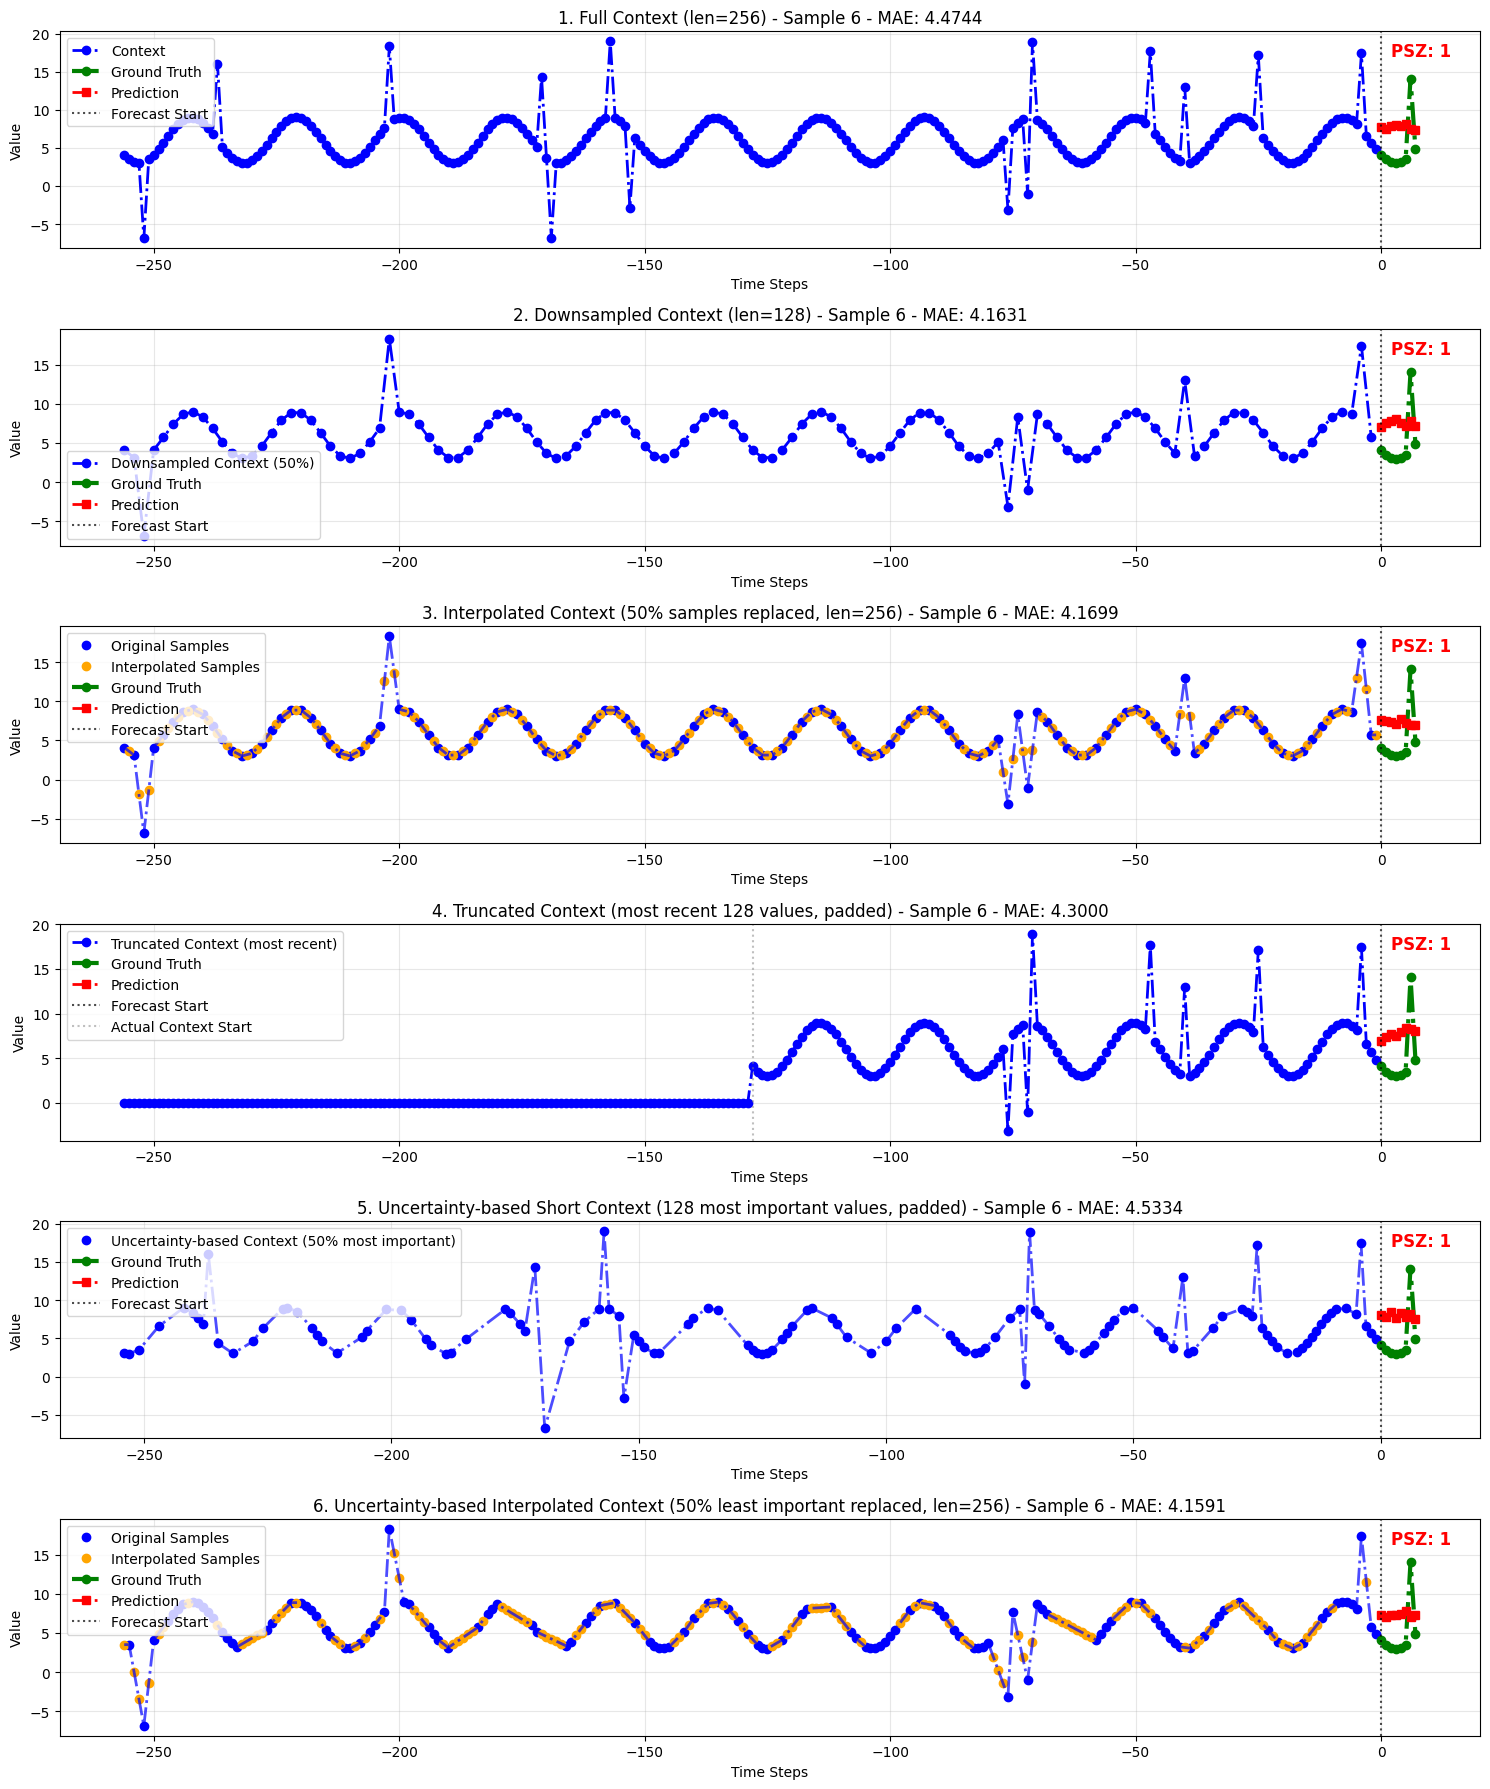

Saved plot: results_prune_1/synthetic_sinusoidal_moirai-large/sample_1_all_methods_comparison.png


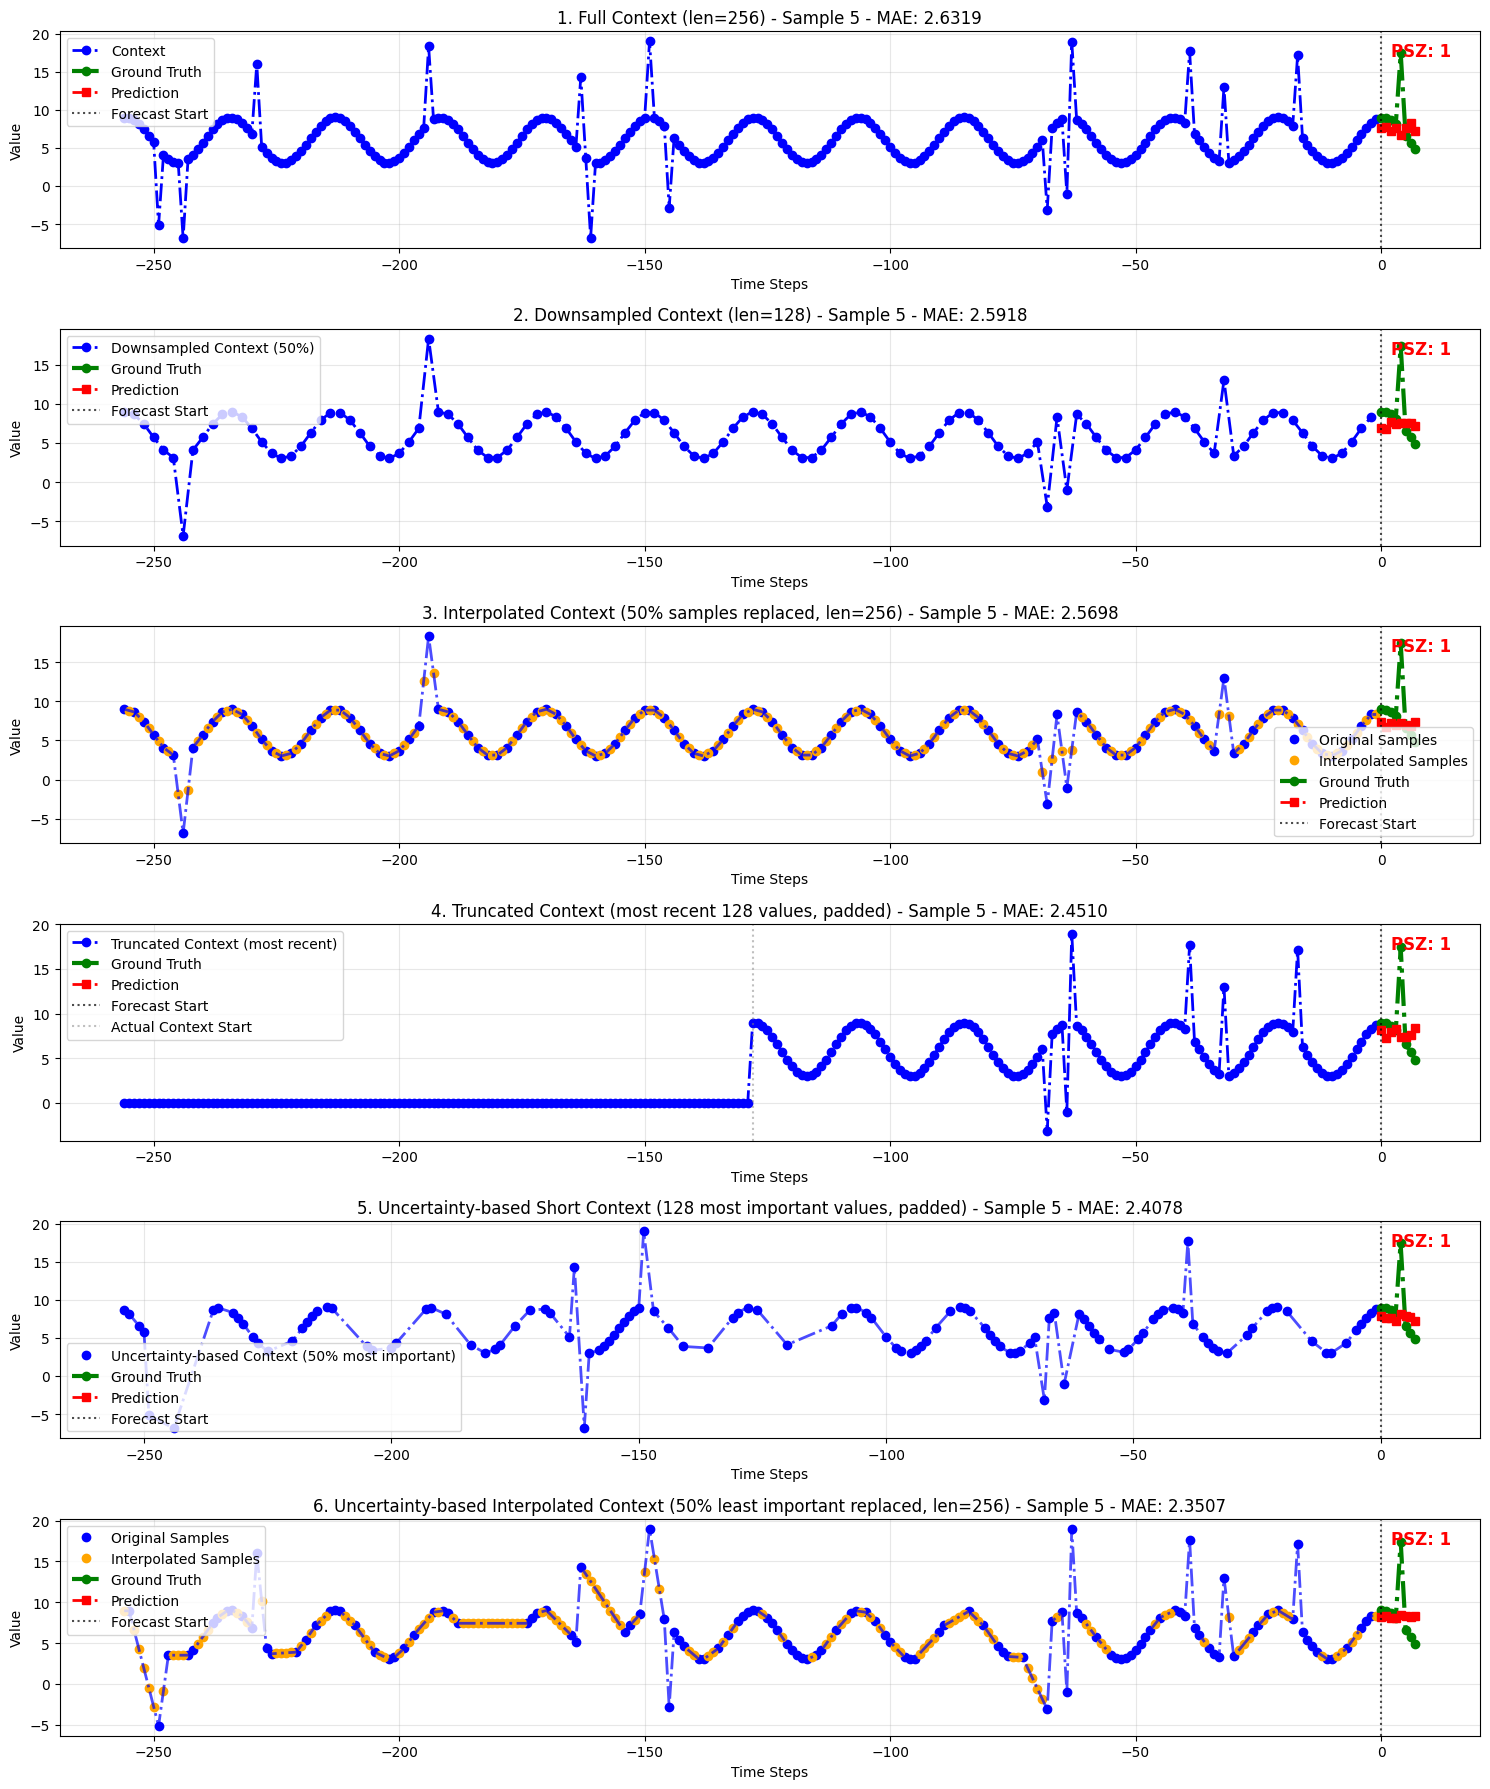

Saved plot: results_prune_1/synthetic_sinusoidal_moirai-large/sample_2_all_methods_comparison.png


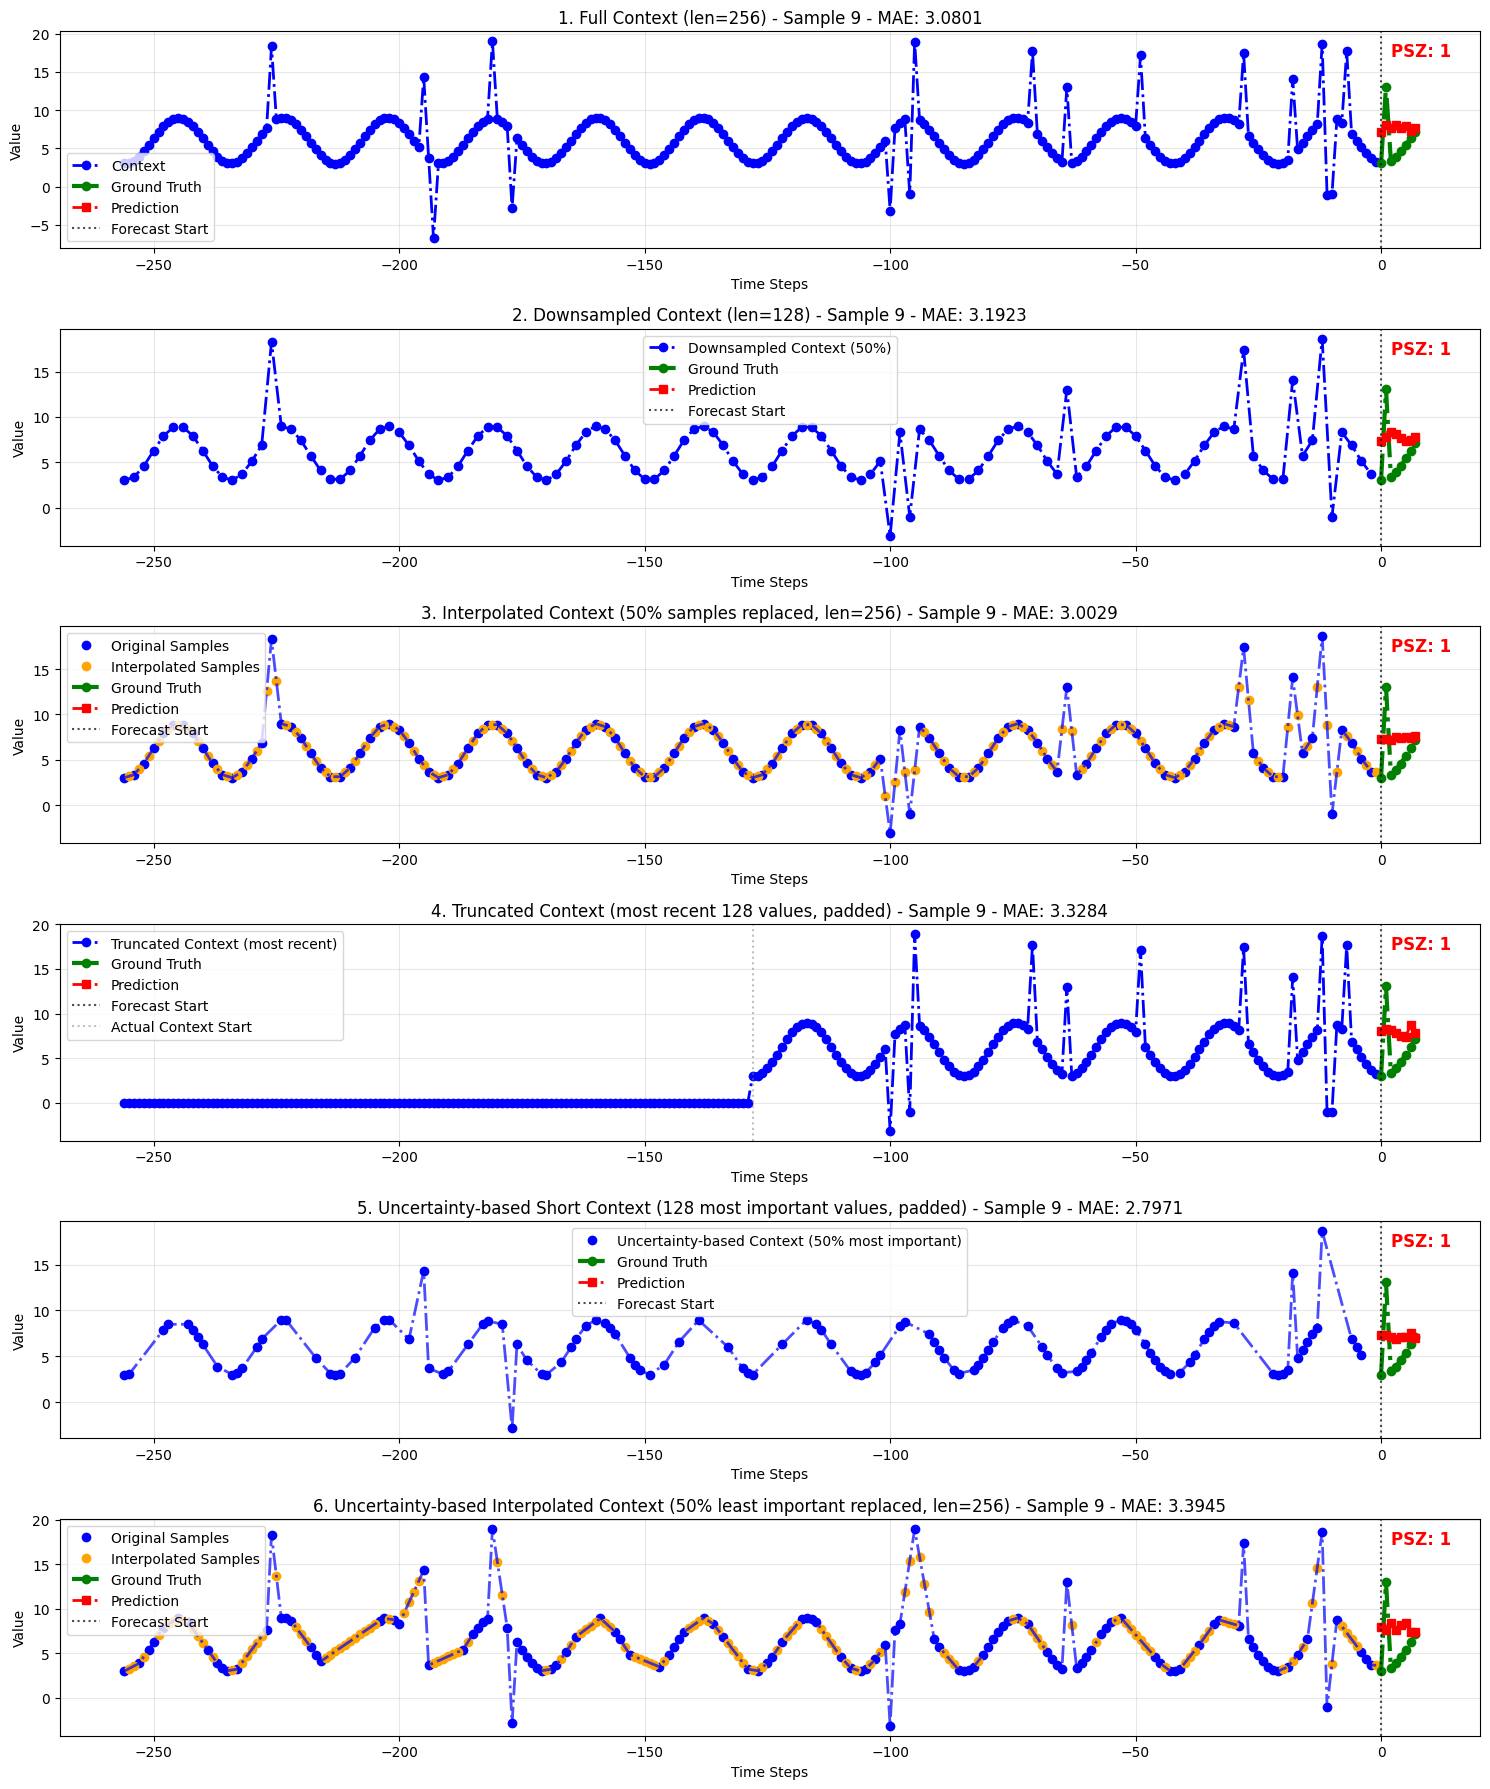

Saved plot: results_prune_1/synthetic_sinusoidal_moirai-large/sample_3_all_methods_comparison.png

Creating summary comparison plot for all methods...


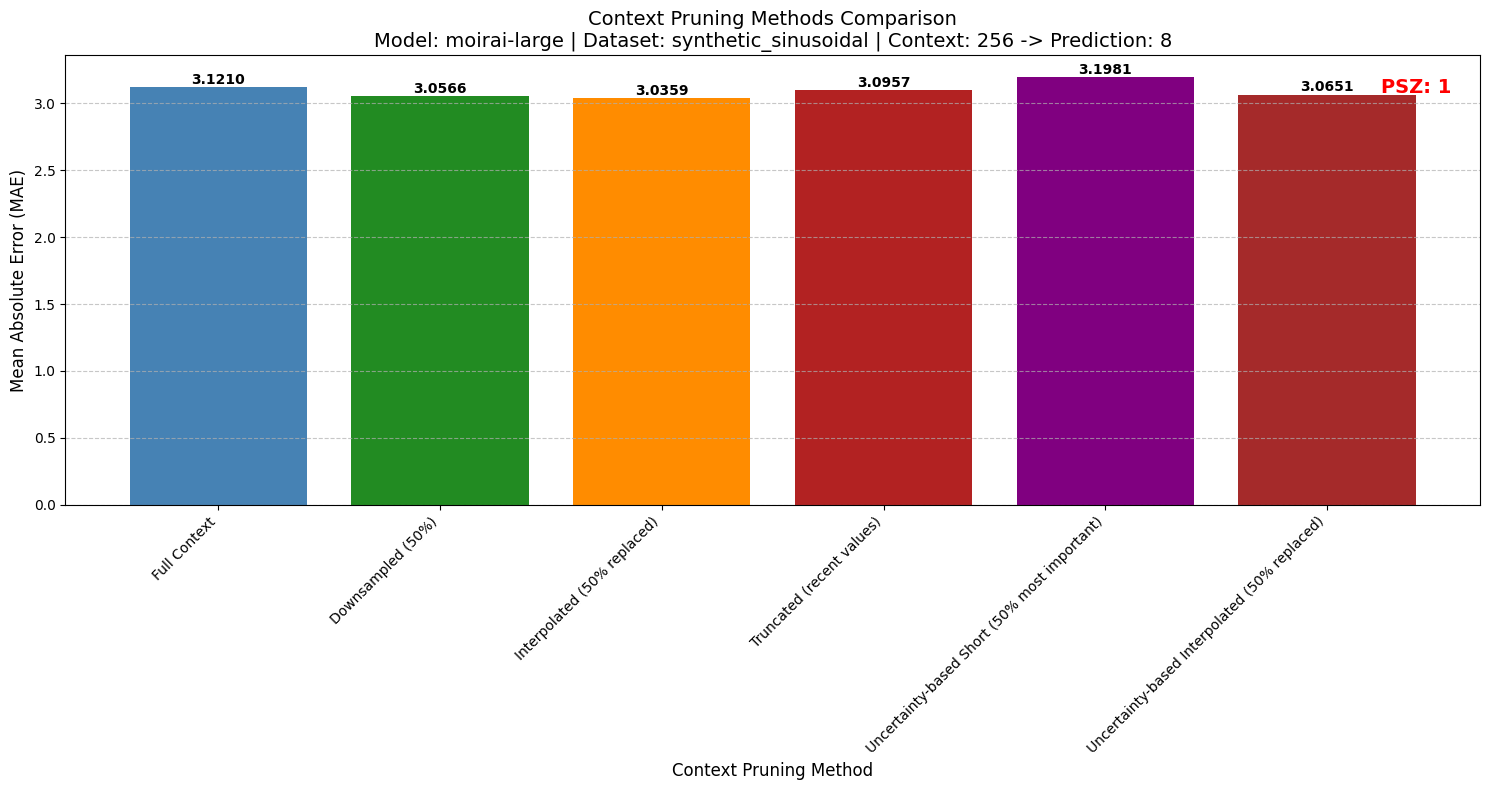

Saved summary plot: results_prune_1/synthetic_sinusoidal_moirai-large/methods_comparison_summary.png

ANALYSIS COMPLETE!
All results and plots saved to: results_prune_1/synthetic_sinusoidal_moirai-large
Best performing method: Interpolated (50% replaced) (MAE: 3.0359)

Performance relative to Full Context (MAE: 3.1210):
  Downsampled (50%)                       : +2.06% (better)
  Interpolated (50% replaced)             : +2.72% (better)
  Truncated (recent values)               : +0.81% (better)
  Uncertainty-based Short (50% most important): -2.47% (worse)
  Uncertainty-based Interpolated (50% replaced): +1.79% (better)


In [52]:
# Plot results for all pruning methods including uncertainty-based approaches
# For 3 random samples, plot context, ground truth and prediction for all 6 methods
num_samples = 3
sample_indices = np.random.choice(len(sample_results), num_samples, replace=False)

for plot_idx, idx in enumerate(sample_indices, 1):
    # Get results for all methods
    result = sample_results[idx]
    result_reduced = sample_results_reduced[idx]
    result_reduced_interpolated = sample_results_reduced_interpolated[idx]
    result_truncated = sample_results_truncated[idx]
    result_uncertainty_short = sample_results_uncertainty_short[idx]
    result_uncertainty_interpolated = sample_results_uncertainty_interpolated[idx]
    
    plt.figure(figsize=(15, 18))  # Increased height for 6 subplots
    
    # 1. Full context
    plt.subplot(6, 1, 1)
    context_len = len(result['context'])
    context_indices = np.arange(-context_len, 0)
    forecast_indices = np.arange(0, PDT)
    
    plt.plot(context_indices, result['context'], label='Context', color='blue', linewidth=2, 
             linestyle='-.', marker='o', markersize=6)
    plt.plot(forecast_indices, result['ground_truth'], label='Ground Truth', color='green', 
             linewidth=3, marker='o', markersize=6, linestyle='-.')
    plt.plot(forecast_indices, result['prediction'], label='Prediction', color='red', 
             linewidth=2, linestyle='-.', marker='s', markersize=6)
    plt.axvline(x=0, color='black', linestyle=':', alpha=0.7, label='Forecast Start')
    
    # Add patch size in red text on top right
    plt.text(0.98, 0.95, f'PSZ: {PSZ}', transform=plt.gca().transAxes, color='red', 
             fontsize=12, fontweight='bold', ha='right', va='top')
    
    plt.title(f"1. Full Context (len={context_len}) - Sample {result['window_id']} - MAE: {result['mae']:.4f}")
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Downsampled context - maintain time scale
    plt.subplot(6, 1, 2)
    context_len_reduced = len(result_reduced['context'])
    
    # Maintain original time scale by spacing the downsampled points appropriately
    # Since we took every 2nd sample, place them at positions corresponding to original indices
    downsampled_indices = np.arange(-context_len_reduced*2, 0, 2)  # Every 2nd position
    
    plt.plot(downsampled_indices, result_reduced['context'], label='Downsampled Context (50%)', 
             color='blue', linewidth=2, linestyle='-.', marker='o', markersize=6)
    plt.plot(forecast_indices, result_reduced['ground_truth'], label='Ground Truth', color='green', 
             linewidth=3, marker='o', markersize=6, linestyle='-.')
    plt.plot(forecast_indices, result_reduced['prediction'], label='Prediction', color='red', 
             linewidth=2, linestyle='-.', marker='s', markersize=6)
    plt.axvline(x=0, color='black', linestyle=':', alpha=0.7, label='Forecast Start')
    
    # Add patch size in red text on top right
    plt.text(0.98, 0.95, f'PSZ: {PSZ}', transform=plt.gca().transAxes, color='red', 
             fontsize=12, fontweight='bold', ha='right', va='top')
    
    plt.title(f"2. Downsampled Context (len={context_len_reduced}) - Sample {result_reduced['window_id']} - MAE: {result_reduced['mae']:.4f}")
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Interpolated context (50% replaced) - highlight interpolated samples
    plt.subplot(6, 1, 3)
    context_len_interpolated = len(result_reduced_interpolated['context'])
    context_indices_interpolated = np.arange(-context_len_interpolated, 0)
    
    # Get the original data to identify which samples were interpolated
    original_context = input_data[idx]['target'][-context_len_interpolated:]
    interpolated_context = result_reduced_interpolated['context']
    
    # Find interpolated positions (where values differ significantly from original)
    interpolated_mask = np.abs(interpolated_context - original_context) > 1e-6
    
    # Plot original samples in blue
    plt.plot(context_indices_interpolated[~interpolated_mask], 
             interpolated_context[~interpolated_mask], 
             'o', color='blue', markersize=6, label='Original Samples')
    
    # Plot interpolated samples in orange
    plt.plot(context_indices_interpolated[interpolated_mask], 
             interpolated_context[interpolated_mask], 
             'o', color='orange', markersize=6, label='Interpolated Samples')
    
    # Connect all points with a line
    plt.plot(context_indices_interpolated, interpolated_context, 
             color='blue', linewidth=2, linestyle='-.', alpha=0.7)
    
    plt.plot(forecast_indices, result_reduced_interpolated['ground_truth'], label='Ground Truth', 
             color='green', linewidth=3, marker='o', markersize=6, linestyle='-.')
    plt.plot(forecast_indices, result_reduced_interpolated['prediction'], label='Prediction', 
             color='red', linewidth=2, linestyle='-.', marker='s', markersize=6)
    plt.axvline(x=0, color='black', linestyle=':', alpha=0.7, label='Forecast Start')
    
    # Add patch size in red text on top right
    plt.text(0.98, 0.95, f'PSZ: {PSZ}', transform=plt.gca().transAxes, color='red', 
             fontsize=12, fontweight='bold', ha='right', va='top')
    
    plt.title(f"3. Interpolated Context (50% samples replaced, len={context_len_interpolated}) - Sample {result_reduced_interpolated['window_id']} - MAE: {result_reduced_interpolated['mae']:.4f}")
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Truncated context (most recent values) - pad with zeros to maintain scale
    plt.subplot(6, 1, 4)
    context_len_truncated = len(result_truncated['context'])
    
    # Pad with zeros to maintain the same scale as full context
    if context_len_truncated < context_len:
        zeros_padding = np.zeros(context_len - context_len_truncated)
        padded_truncated_context = np.concatenate([zeros_padding, result_truncated['context']])
        truncated_indices = np.arange(-context_len, 0)
        context_start_line = -context_len_truncated
    else:
        padded_truncated_context = result_truncated['context']
        truncated_indices = np.arange(-context_len_truncated, 0)
        context_start_line = -context_len_truncated
    
    plt.plot(truncated_indices, padded_truncated_context, label='Truncated Context (most recent)', 
             color='blue', linewidth=2, linestyle='-.', marker='o', markersize=6)
    plt.plot(forecast_indices, result_truncated['ground_truth'], label='Ground Truth', 
             color='green', linewidth=3, marker='o', markersize=6, linestyle='-.')
    plt.plot(forecast_indices, result_truncated['prediction'], label='Prediction', 
             color='red', linewidth=2, linestyle='-.', marker='s', markersize=6)
    plt.axvline(x=0, color='black', linestyle=':', alpha=0.7, label='Forecast Start')
    plt.axvline(x=context_start_line, color='gray', linestyle=':', alpha=0.5, label='Actual Context Start')
    
    # Add patch size in red text on top right
    plt.text(0.98, 0.95, f'PSZ: {PSZ}', transform=plt.gca().transAxes, color='red', 
             fontsize=12, fontweight='bold', ha='right', va='top')
    
    plt.title(f"4. Truncated Context (most recent {context_len_truncated} values, padded) - Sample {result_truncated['window_id']} - MAE: {result_truncated['mae']:.4f}")
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Uncertainty-based short context - maintain time scale with padding
    plt.subplot(6, 1, 5)
    context_len_unc_short = len(result_uncertainty_short['context'])
    
    # For uncertainty-based short context, we need to map the selected important samples
    # back to their original time positions within the last CTX samples
    # Get the original context to determine which samples were kept
    original_last_ctx = input_data[idx]['target'][-CTX:]
    
    # Find which indices were kept by comparing values
    kept_indices = []
    unc_context = result_uncertainty_short['context']
    for i, val in enumerate(unc_context):
        # Find the closest match in the original last CTX samples
        closest_idx = np.argmin(np.abs(original_last_ctx - val))
        kept_indices.append(closest_idx)
    
    # Create time indices for the kept samples (relative to end of context)
    unc_time_indices = np.array(kept_indices) - CTX
    
    # Pad with zeros to maintain scale
    if context_len_unc_short < context_len:
        # Create a padded array with zeros
        padded_unc_context = np.zeros(context_len)
        # Map the kept samples to their correct positions
        for i, (time_idx, val) in enumerate(zip(unc_time_indices, unc_context)):
            padded_unc_context[time_idx + context_len] = val
        
        padded_indices = np.arange(-context_len, 0)
        
        # Plot only non-zero values as points
        non_zero_mask = padded_unc_context != 0
        plt.plot(padded_indices[non_zero_mask], padded_unc_context[non_zero_mask], 
                'o', color='blue', markersize=6, label='Uncertainty-based Context (50% most important)')
        # Connect with lines
        plt.plot(padded_indices[non_zero_mask], padded_unc_context[non_zero_mask], 
                color='blue', linewidth=2, linestyle='-.', alpha=0.7)
    else:
        plt.plot(unc_time_indices, unc_context, 'o-', color='blue', linewidth=2, 
                 linestyle='-.', markersize=6, label='Uncertainty-based Context (50% most important)')
    
    plt.plot(forecast_indices, result_uncertainty_short['ground_truth'], label='Ground Truth', 
             color='green', linewidth=3, marker='o', markersize=6, linestyle='-.')
    plt.plot(forecast_indices, result_uncertainty_short['prediction'], label='Prediction', 
             color='red', linewidth=2, linestyle='-.', marker='s', markersize=6)
    plt.axvline(x=0, color='black', linestyle=':', alpha=0.7, label='Forecast Start')
    
    # Add patch size in red text on top right
    plt.text(0.98, 0.95, f'PSZ: {PSZ}', transform=plt.gca().transAxes, color='red', 
             fontsize=12, fontweight='bold', ha='right', va='top')
    
    plt.title(f"5. Uncertainty-based Short Context ({context_len_unc_short} most important values, padded) - Sample {result_uncertainty_short['window_id']} - MAE: {result_uncertainty_short['mae']:.4f}")
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Uncertainty-based interpolated context - highlight interpolated samples
    plt.subplot(6, 1, 6)
    context_len_unc_interp = len(result_uncertainty_interpolated['context'])
    context_indices_unc_interp = np.arange(-context_len_unc_interp, 0)
    
    # Get the original last CTX samples to identify which were interpolated
    original_last_ctx = input_data[idx]['target'][-CTX:]
    unc_interpolated_context = result_uncertainty_interpolated['context']
    
    # Find interpolated positions (where values differ from original)
    unc_interpolated_mask = np.abs(unc_interpolated_context - original_last_ctx) > 1e-6
    
    # Plot original samples in blue
    plt.plot(context_indices_unc_interp[~unc_interpolated_mask], 
             unc_interpolated_context[~unc_interpolated_mask], 
             'o', color='blue', markersize=6, label='Original Samples')
    
    # Plot interpolated samples in orange
    plt.plot(context_indices_unc_interp[unc_interpolated_mask], 
             unc_interpolated_context[unc_interpolated_mask], 
             'o', color='orange', markersize=6, label='Interpolated Samples')
    
    # Connect all points with a line
    plt.plot(context_indices_unc_interp, unc_interpolated_context, 
             color='blue', linewidth=2, linestyle='-.', alpha=0.7)
    
    plt.plot(forecast_indices, result_uncertainty_interpolated['ground_truth'], label='Ground Truth', 
             color='green', linewidth=3, marker='o', markersize=6, linestyle='-.')
    plt.plot(forecast_indices, result_uncertainty_interpolated['prediction'], label='Prediction', 
             color='red', linewidth=2, linestyle='-.', marker='s', markersize=6)
    plt.axvline(x=0, color='black', linestyle=':', alpha=0.7, label='Forecast Start')
    
    # Add patch size in red text on top right
    plt.text(0.98, 0.95, f'PSZ: {PSZ}', transform=plt.gca().transAxes, color='red', 
             fontsize=12, fontweight='bold', ha='right', va='top')
    
    plt.title(f"6. Uncertainty-based Interpolated Context (50% least important replaced, len={context_len_unc_interp}) - Sample {result_uncertainty_interpolated['window_id']} - MAE: {result_uncertainty_interpolated['mae']:.4f}")
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save plot
    plot_filename = os.path.join(results_dir, f"sample_{plot_idx}_all_methods_comparison.png")
    plt.tight_layout()
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved plot: {plot_filename}")

# Create summary comparison plot
print("\nCreating summary comparison plot for all methods...")
plt.figure(figsize=(15, 8))

methods = list(methods_summary.keys())
mae_values = list(methods_summary.values())

bars = plt.bar(range(len(methods)), mae_values, 
               color=['steelblue', 'forestgreen', 'darkorange', 'firebrick', 'purple', 'brown'])

# Add MAE values on top of bars
for i, (bar, mae) in enumerate(zip(bars, mae_values)):
    plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height() + 0.001, 
             f'{mae:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Context Pruning Method', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)

# Add patch size in red text on top right of the summary plot
plt.text(0.98, 0.95, f'PSZ: {PSZ}', transform=plt.gca().transAxes, color='red', 
         fontsize=14, fontweight='bold', ha='right', va='top')

plt.title(f'Context Pruning Methods Comparison\nModel: {MODEL}-{SIZE} | Dataset: {dataset_name} | Context: {CTX} -> Prediction: {PDT}', fontsize=14)
plt.xticks(range(len(methods)), methods, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save summary plot
summary_filename = os.path.join(results_dir, "methods_comparison_summary.png")
plt.savefig(summary_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved summary plot: {summary_filename}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print(f"All results and plots saved to: {results_dir}")
print(f"Best performing method: {best_method[0]} (MAE: {best_method[1]:.4f})")

# Calculate improvement percentages
full_context_mae = methods_summary['Full Context']
print(f"\nPerformance relative to Full Context (MAE: {full_context_mae:.4f}):")
for method, mae in methods_summary.items():
    if method != 'Full Context':
        improvement = ((full_context_mae - mae) / full_context_mae) * 100
        status = "better" if improvement > 0 else "worse"
        print(f"  {method:<40}: {improvement:+.2f}% ({status})")



Creating uncertainty and delta analysis plots for selected samples...


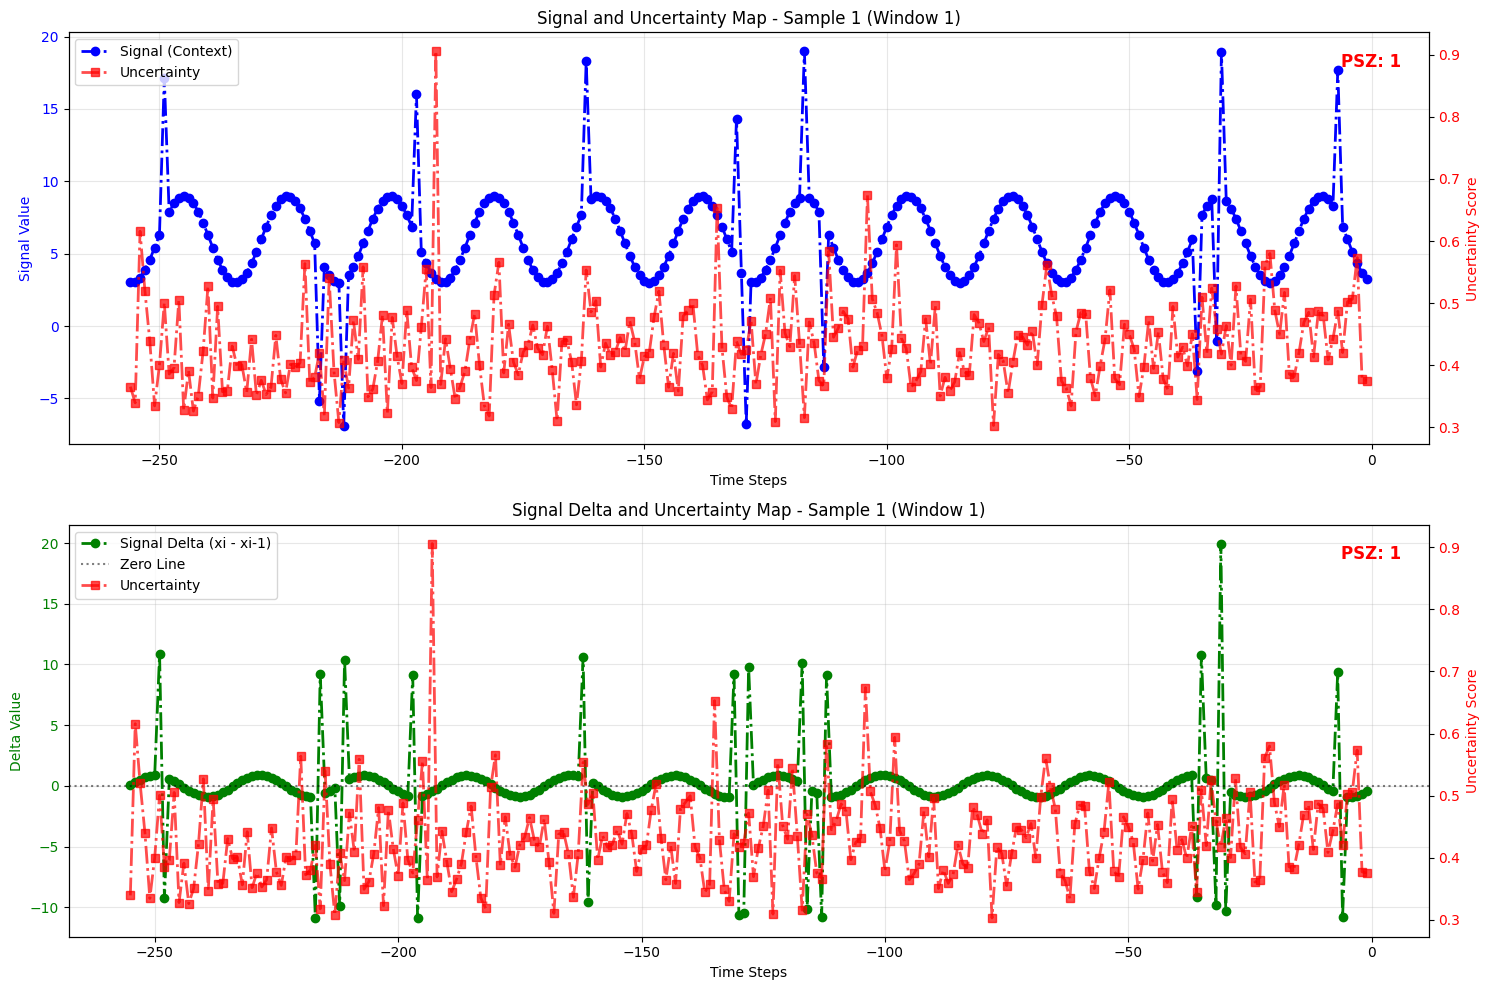

Saved uncertainty and delta analysis plot: results_prune_1/synthetic_sinusoidal_moirai-large/sample_1_uncertainty_delta_analysis.png


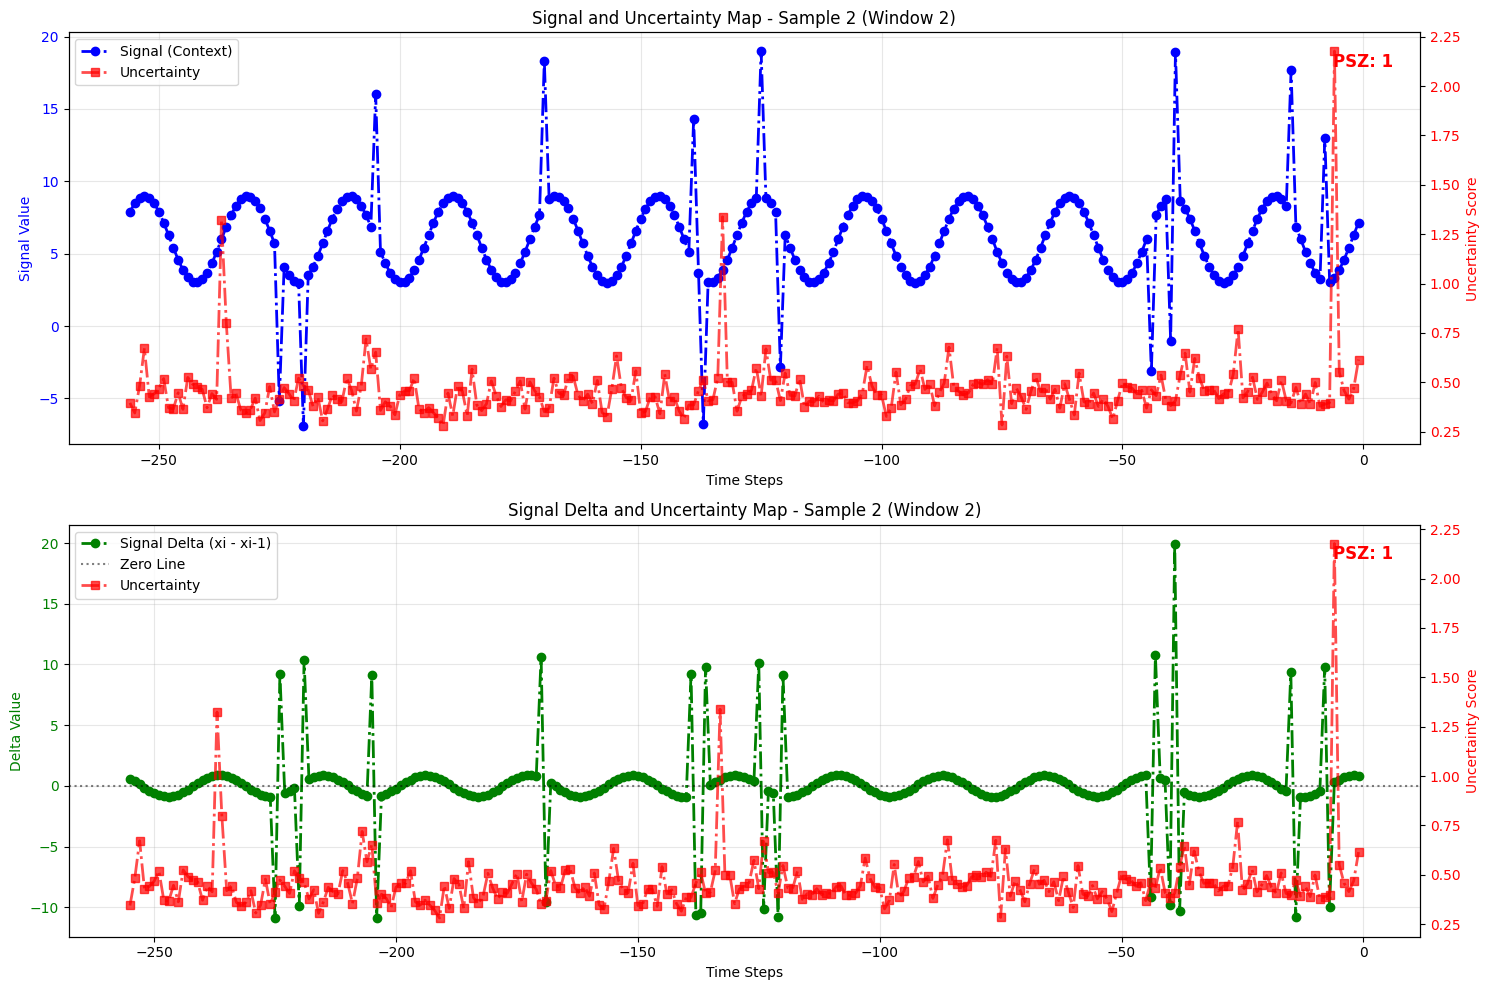

Saved uncertainty and delta analysis plot: results_prune_1/synthetic_sinusoidal_moirai-large/sample_2_uncertainty_delta_analysis.png


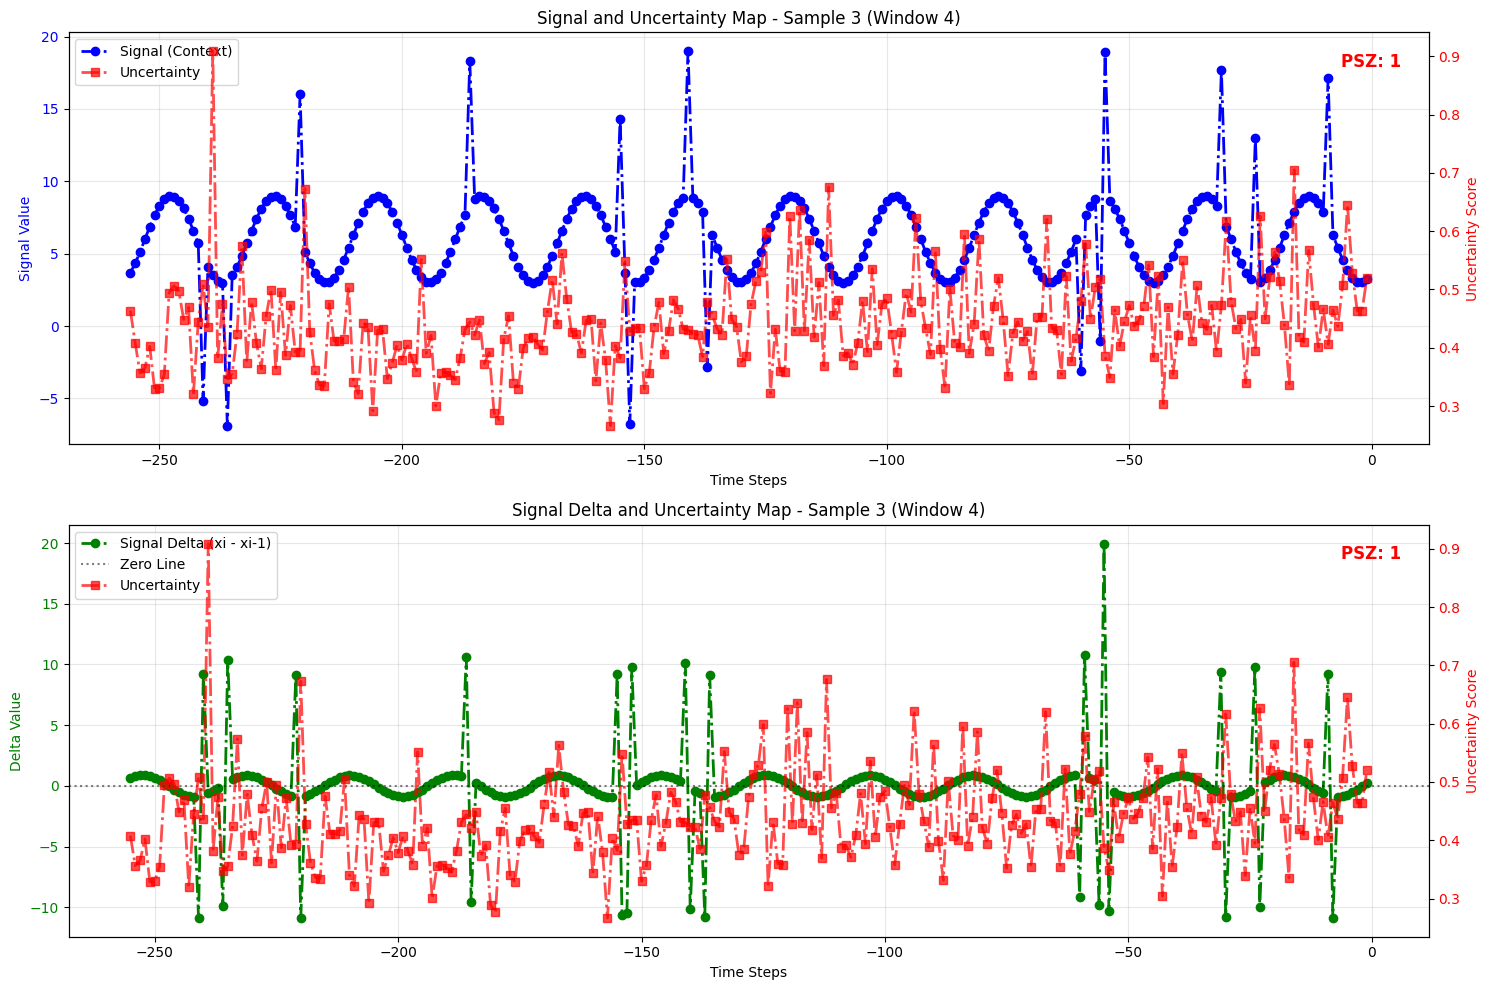

Saved uncertainty and delta analysis plot: results_prune_1/synthetic_sinusoidal_moirai-large/sample_3_uncertainty_delta_analysis.png

Uncertainty and delta analysis complete!


In [53]:
# Create uncertainty and delta analysis plots for the 3 selected samples
print("\nCreating uncertainty and delta analysis plots for selected samples...")

# Select 3 random samples for detailed analysis
num_samples = 3
sample_indices = np.random.choice(len(sample_results), num_samples, replace=False)

for plot_idx, idx in enumerate(sample_indices, 1):
    # Get the stored uncertainty data for this sample
    if idx in selected_samples_data:
        sample_data = selected_samples_data[idx]
        signal = sample_data['signal']
        uncertainty = sample_data['uncertainty']
        delta = sample_data['delta']  # delta[i] = x[i] - x[i-1], delta[0] = 0
        
        # Create figure with 2 subplots for each sample
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Plot 1: Signal and Uncertainty Map
        ax1_twin = ax1.twinx()  # Create twin axis for uncertainty
        
        # Plot the signal (last CTX samples)
        ctx_indices = np.arange(-CTX, 0)
        line1 = ax1.plot(ctx_indices, signal, 'o-', color='blue', linewidth=2, 
                        linestyle='-.', markersize=6, label='Signal (Context)')
        ax1.set_xlabel('Time Steps')
        ax1.set_ylabel('Signal Value', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(True, alpha=0.3)
        
        # Plot the uncertainty map
        line2 = ax1_twin.plot(ctx_indices, uncertainty, 's-', color='red', linewidth=2, 
                             linestyle='-.', markersize=6, alpha=0.7, label='Uncertainty')
        ax1_twin.set_ylabel('Uncertainty Score', color='red')
        ax1_twin.tick_params(axis='y', labelcolor='red')
        
        # Add patch size in red text on top right
        ax1.text(0.98, 0.95, f'PSZ: {PSZ}', transform=ax1.transAxes, color='red', 
                fontsize=12, fontweight='bold', ha='right', va='top')
        
        # Create combined legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_twin.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        ax1.set_title(f'Signal and Uncertainty Map - Sample {plot_idx} (Window {sample_results[idx]["window_id"]})')
        
        # Plot 2: Delta and Uncertainty Map
        ax2_twin = ax2.twinx()  # Create twin axis for uncertainty
        
        # Plot deltas: delta[i] = x[i] - x[i-1] at position i
        # We skip the first position (i=0) since delta[0] = 0 (no previous value)
        delta_positions = ctx_indices[1:]  # Skip first position
        delta_values = delta[1:]  # Skip delta[0] which is 0
        uncertainty_for_delta = uncertainty[1:]  # Corresponding uncertainty values
        
        line3 = ax2.plot(delta_positions, delta_values, 'o-', color='green', linewidth=2, 
                        linestyle='-.', markersize=6, label='Signal Delta (xi - xi-1)')
        ax2.axhline(y=0, color='black', linestyle=':', alpha=0.5, label='Zero Line')
        ax2.set_xlabel('Time Steps')
        ax2.set_ylabel('Delta Value', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.grid(True, alpha=0.3)
        
        # Plot the uncertainty map for delta positions
        line4 = ax2_twin.plot(delta_positions, uncertainty_for_delta, 's-', color='red', linewidth=2, 
                             linestyle='-.', markersize=6, alpha=0.7, label='Uncertainty')
        ax2_twin.set_ylabel('Uncertainty Score', color='red')
        ax2_twin.tick_params(axis='y', labelcolor='red')
        
        # Add patch size in red text on top right
        ax2.text(0.98, 0.95, f'PSZ: {PSZ}', transform=ax2.transAxes, color='red', 
                fontsize=12, fontweight='bold', ha='right', va='top')
        
        # Create combined legend
        lines3, labels3 = ax2.get_legend_handles_labels()
        lines4, labels4 = ax2_twin.get_legend_handles_labels()
        ax2.legend(lines3 + lines4, labels3 + labels4, loc='upper left')
        
        ax2.set_title(f'Signal Delta and Uncertainty Map - Sample {plot_idx} (Window {sample_results[idx]["window_id"]})')
        
        # Save the uncertainty and delta analysis plot
        uncertainty_plot_filename = os.path.join(results_dir, f"sample_{plot_idx}_uncertainty_delta_analysis.png")
        plt.tight_layout()
        plt.savefig(uncertainty_plot_filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Saved uncertainty and delta analysis plot: {uncertainty_plot_filename}")
        
    else:
        print(f"Warning: No uncertainty data available for sample {idx} (plot {plot_idx})")

print("\nUncertainty and delta analysis complete!")